# Multi Head Mechanism
Multiple Self Attention Mechanism are Stacked Parallely

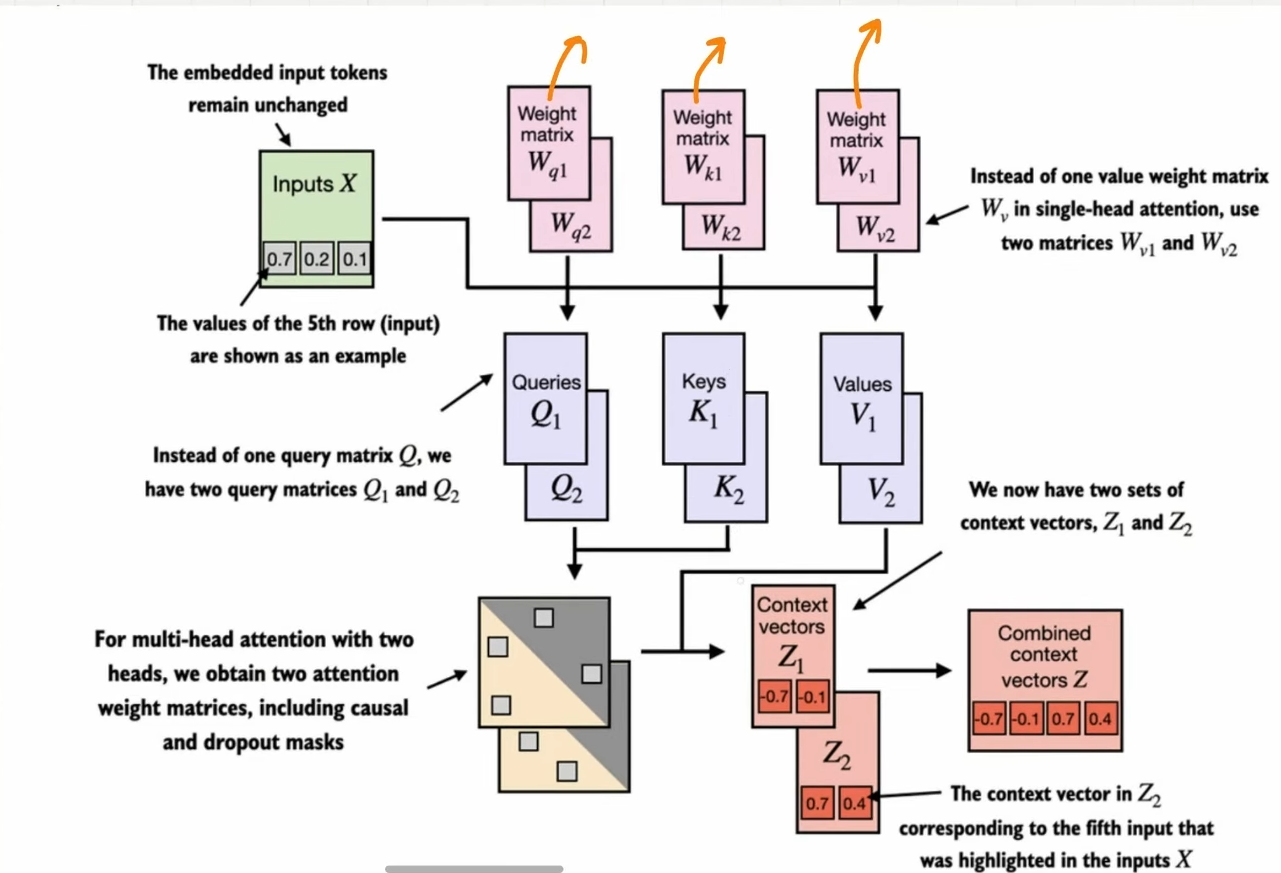

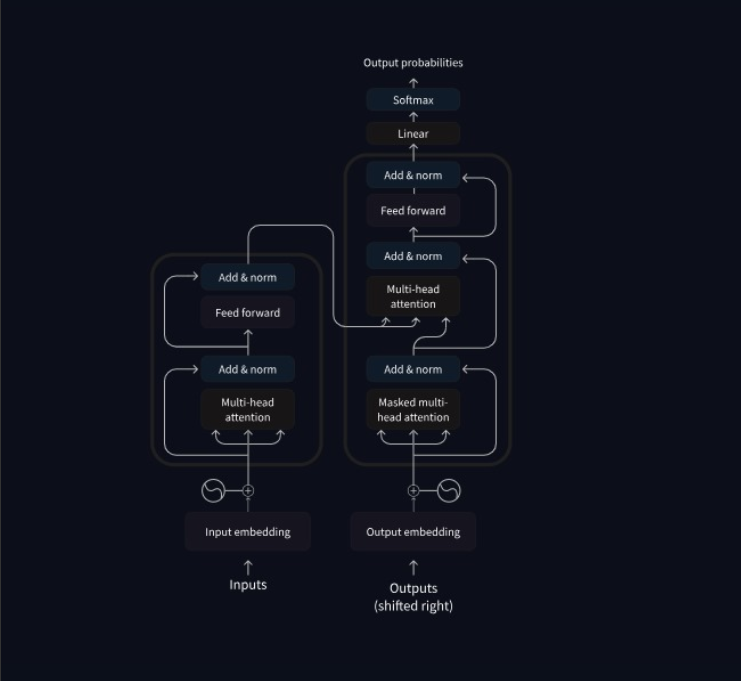

In [2]:
import torch
import torch.nn as nn

In [3]:
# Input Embedding Matrix
inputs = torch.tensor (
    [[0.43, 0.15, 0.89],  #(x^1) Your
     [0.55, 0.87, 0.66],  #(x^2) journey
     [0.57, 0.85, 0.64],  #(x^3) starts
     [0.22, 0.58, 0.33],  #(x^4) with
     [0.77, 0.25, 0.10],  #(x^5) one
     [0.05, 0.80, 0.55]]  #(x^6) step
)

In [4]:
dimIn = inputs.shape[1] # Columns(3)
dimOut = 2

In [5]:
class CausalMechanismV1(nn.Module):
  def __init__(self, dimIn, dimOut, contextLen, dropout, qkv_bias=False):
    super().__init__()
    self.dimOut = dimOut
    self.wQuery = nn.Linear(dimIn, dimOut, bias=qkv_bias)
    self.wKey = nn.Linear(dimIn, dimOut, bias=qkv_bias)
    self.wValue = nn.Linear(dimIn, dimOut, bias=qkv_bias)
    self.dropout = nn.Dropout(dropout)
    self.register_buffer('mask', torch.triu(torch.ones(contextLen, contextLen), diagonal=1))

  def forward(self, x):
    batches, numTokens, dimIn = x.shape
    queryMat = self.wQuery(x)
    keyMat = self.wKey(x)
    valueMat = self.wValue(x)

    attentionScoreMatrix = queryMat @ keyMat.transpose(1, 2)
    attentionScoreMatrix.masked_fill_(self.mask.bool()[:numTokens, :numTokens], -torch.inf)
    attentionScoreMat = torch.softmax(attentionScoreMatrix/keyMat.shape[-1]**0.5, dim=-1)
    attentionScoreMat = self.dropout(attentionScoreMat)

    contextVectorMat = attentionScoreMat @ valueMat
    return contextVectorMat

#Extending Single Head Attention To Multi Head Attention

* Multiple instances of self attention mechanism each with its own trainable weights and combing there outputs



In [6]:
class MultiHeadAttentionWrapper(nn.Module):
  def __init__(self, dimIn, dimOut, contextLen, dropout, numOfHeads, qkv_bias = False):
    super().__init__()
    self.heads = nn.ModuleList(
        [CausalMechanismV1(dimIn, dimOut, contextLen, dropout, qkv_bias)
        for _ in range(numOfHeads)]
    )

  def forward(self, x):
    return torch.cat([head(x) for head in self.heads], dim=-1)  # Concatinate all the outputs together
# In above code the no of heads we will pass it will create that must instances of Causal and then at the end will concatinate all together


In [7]:
batch = torch.stack((inputs, inputs), dim = 0)
print(batch)
print(batch.shape) # 2 Batches/ Tensor of shape 6(tokens)x3(3 dimensional vector)

tensor([[[0.4300, 0.1500, 0.8900],
         [0.5500, 0.8700, 0.6600],
         [0.5700, 0.8500, 0.6400],
         [0.2200, 0.5800, 0.3300],
         [0.7700, 0.2500, 0.1000],
         [0.0500, 0.8000, 0.5500]],

        [[0.4300, 0.1500, 0.8900],
         [0.5500, 0.8700, 0.6600],
         [0.5700, 0.8500, 0.6400],
         [0.2200, 0.5800, 0.3300],
         [0.7700, 0.2500, 0.1000],
         [0.0500, 0.8000, 0.5500]]])
torch.Size([2, 6, 3])


In [8]:
torch.manual_seed(123)
contextLen = batch.shape[1]
mh = MultiHeadAttentionWrapper(dimIn, dimOut, contextLen, 0.0, numOfHeads= 2)
contextvectors = mh(batch)
print(contextvectors)
print(contextvectors.shape)

tensor([[[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]],

        [[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]]], grad_fn=<CatBackward0>)
torch.Size([2, 6, 4])


# Implementing Multi-Head Attention With Weight Splits

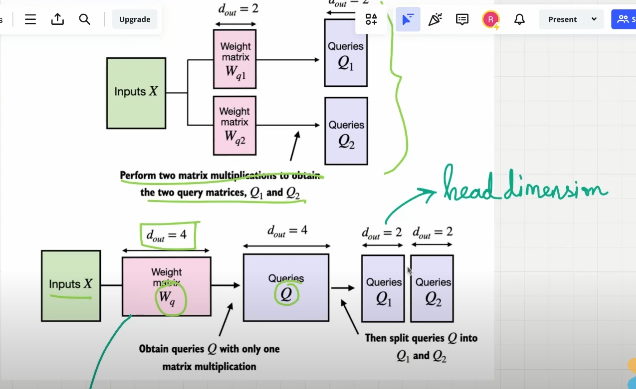

  Splitting the input into multiple heads by reshaping the projected query, key, value tensors and then combines the result from these heads after computing attention

In [46]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

In [47]:
torch.manual_seed(123)

# Define the tensor with 3 rows and 6 columns
inputs = torch.tensor(
    [[0.43, 0.15, 0.89, 0.55, 0.87, 0.66],  # Row 1
     [0.57, 0.85, 0.64, 0.22, 0.58, 0.33],  # Row 2
     [0.77, 0.25, 0.10, 0.05, 0.80, 0.55]]  # Row 3
)

batch = torch.stack((inputs, inputs), dim=0)
print(batch.shape)

batch_size, context_length, d_in = batch.shape
d_out = 6
mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=2)
context_vecs = mha(batch)
print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

torch.Size([2, 3, 6])
tensor([[[ 0.1569, -0.0873,  0.0210,  0.0215, -0.3243, -0.2518],
         [ 0.1117, -0.0547,  0.0406, -0.0213, -0.3251, -0.2993],
         [ 0.1196, -0.0491,  0.0318, -0.0635, -0.2788, -0.2578]],

        [[ 0.1569, -0.0873,  0.0210,  0.0215, -0.3243, -0.2518],
         [ 0.1117, -0.0547,  0.0406, -0.0213, -0.3251, -0.2993],
         [ 0.1196, -0.0491,  0.0318, -0.0635, -0.2788, -0.2578]]],
       grad_fn=<ViewBackward0>)
context_vecs.shape: torch.Size([2, 3, 6])
